In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)



In [15]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadatas, tracklets_joined = import_tracklets(datapath, roots)
for root in roots:
    spots[root]["e_id"] = [f"{root}_{idx}" for idx in spots[root].ID]
    spots[root]["e_parent_id"] = [f"{root}_{idx}" for idx in spots[root].parent_id]
    spots[root]["e_track_id"] = [f"{root}_{idx}" for idx in spots[root].track_id]
    spots[root]["e_tracklet_id"] = [f"{root}_{idx}" for idx in spots[root].tracklet_id]
    spots[root]["embryo"] = root
    spots[root]["d_poles"] = 0.5 - np.abs(spots[root].ap_position - 0.5)
    
    for categorical_col in ["e_id", "e_parent_id", "e_track_id", "e_tracklet_id", "embryo", "track_id", "tracklet_id"]:
        spots[root][categorical_col] = pd.Categorical(spots[root][categorical_col])
    
spots_joined = pd.concat(spots.values(), ignore_index=True)
spots_joined.set_index("e_id", inplace=True)
print(spots_joined.columns)
print(tracklets_joined.columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle', 'e_parent_id', 'e_track_id', 'e_tracklet_id', 'embryo',
       'd_poles'],
      dtype='object')
Index(['start_time', 'end_time', 'start_frame', 'end_frame', 'length',
       'source_spot', 'sink_spot', 'mean_ap_position', 'source_ap_position',
       'sink_ap_position', 'initial_x', 'initial_y', 'final_x', 'final_y',
       'track_id', 'mean_edge_distance', 'track_n_tracklets', 'cycle',
       'embryo', 'tracklet_id', 'parent_tracklet', 'n_children',
       'e_parent_id'],
      dtype='object')


0


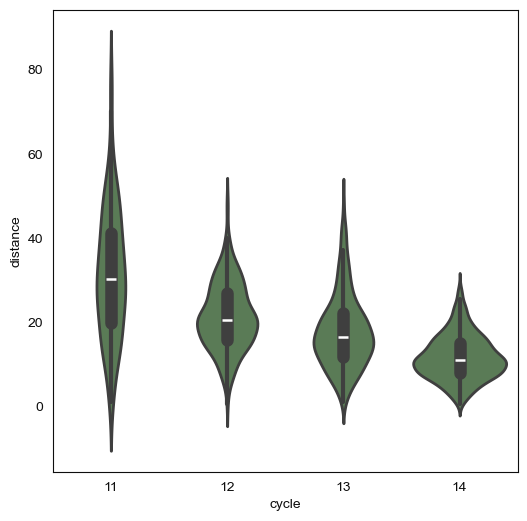

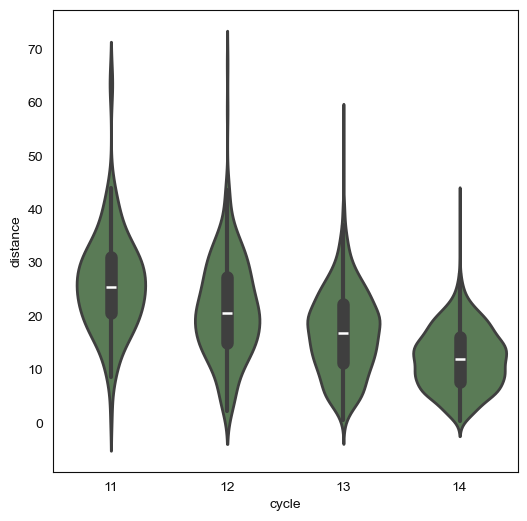

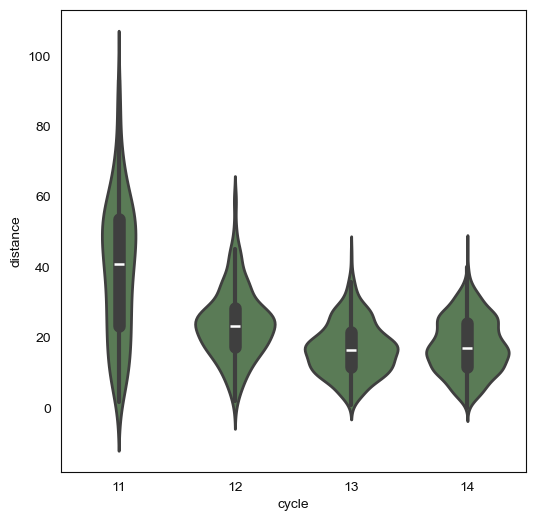

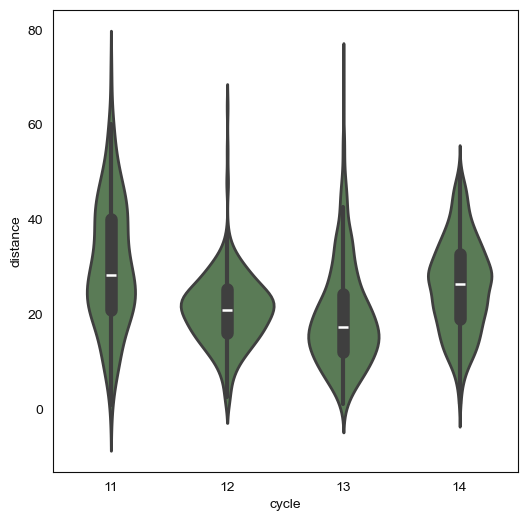

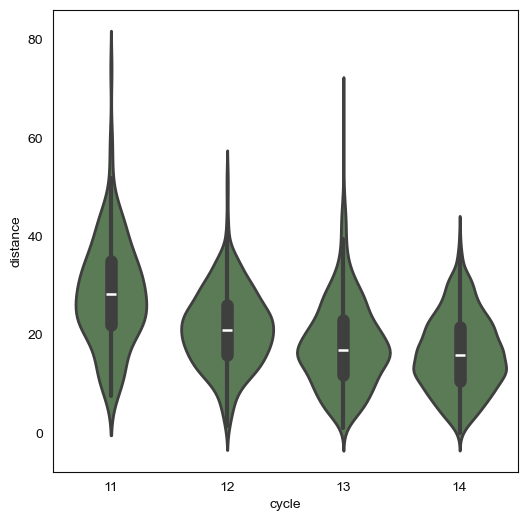

In [36]:
tracklets_joined["x_vector"] = tracklets_joined["e_parent_id"].map(tracklets_joined["final_x"]) - tracklets_joined["final_x"]
tracklets_joined["y_vector"] = tracklets_joined["e_parent_id"].map(tracklets_joined["final_y"]) - tracklets_joined["final_y"]
tracklets_joined["distance"] = np.sqrt(tracklets_joined["x_vector"]**2 + tracklets_joined["y_vector"]**2)

print(tracklets_joined[tracklets_joined["parent_tracklet"] != -1]["x_vector"].isna().sum())

for root in roots:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    t = tracklets_joined[tracklets_joined["embryo"]==root]
    t = t[t["parent_tracklet"] > 0]
    sns.violinplot(data=t, x="cycle", y="distance", ax=ax, color=palette["green"], linewidth=2)
    plt.show()

# for cycle in range(11, 15):
#     fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
#     for root, ax in zip(roots[1:], axes.flatten()):
#         # fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#         t = tracklets_joined[(tracklets_joined["embryo"]==root) & (tracklets_joined["cycle"]==cycle)]
#         t = t[t["parent_tracklet"] > 0]
# 
#         sns.scatterplot(data=t, x="final_x", y="final_y", ax=ax, s=10, color=palette["green"], legend=False, linewidths=0)
#         x, y = t["final_x"], t["final_y"]
#         u, v = t["x_vector"], t["y_vector"]
#         ax.quiver(x, y, u, v, color="black", scale=1, scale_units="xy")
#         ax.set_title(root)
# 
#     plt.suptitle(f"Cycle {cycle}")
#     plt.tight_layout()
#     this_plotpath = plotpath / "disquiver"
#     this_plotpath.mkdir(exist_ok=True)
#     plt.savefig(this_plotpath / f"cycle_{cycle}_root_{root}.png", dpi=300)
#     plt.show()

In [4]:
fully_tracked = spots_joined[spots_joined["track_n_tracklets"] == 31]

In [8]:
spot_df = spots_joined[(spots_joined["track_n_tracklets"] >= 16) & 
                  (spots_joined["track_id"] != 0)].copy()

spot_df["distance_from_start"] = np.sqrt((spot_df["um_x"] - spot_df["e_track_id"].map(spot_df.groupby("e_track_id").first()["um_x"]))**2 + 
                                         (spot_df["um_y"] - spot_df["e_track_id"].map(spot_df.groupby("e_track_id").first()["um_y"]))**2)

x = spot_df.ap_position
spot_df["ap_axis_bin"] = np.digitize(x, np.linspace(x.min(), x.max()+0.0001, 10)) * (x.max() - x.min()) / 10 + x.min()

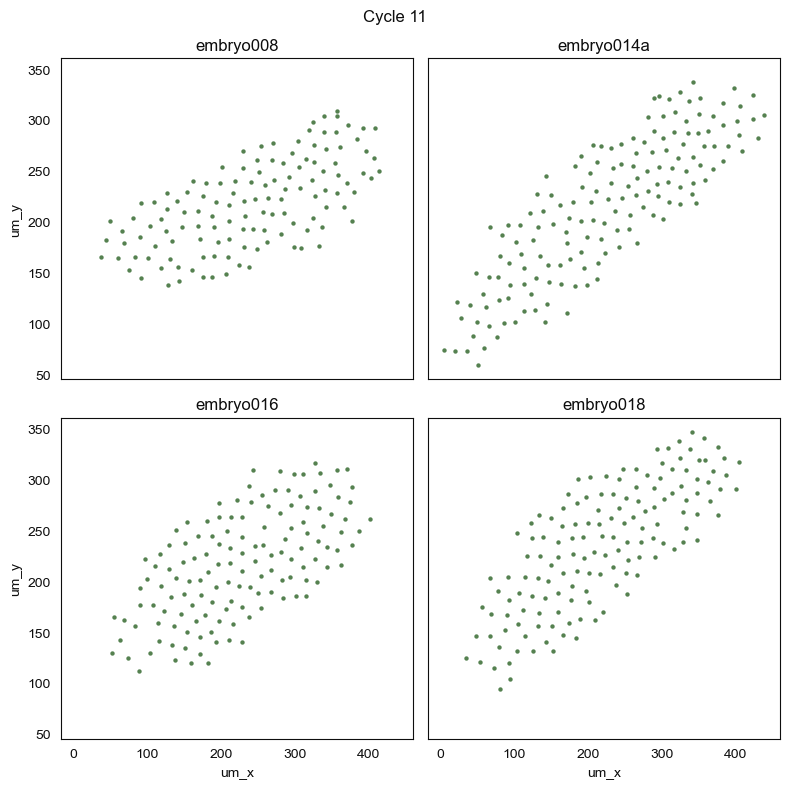

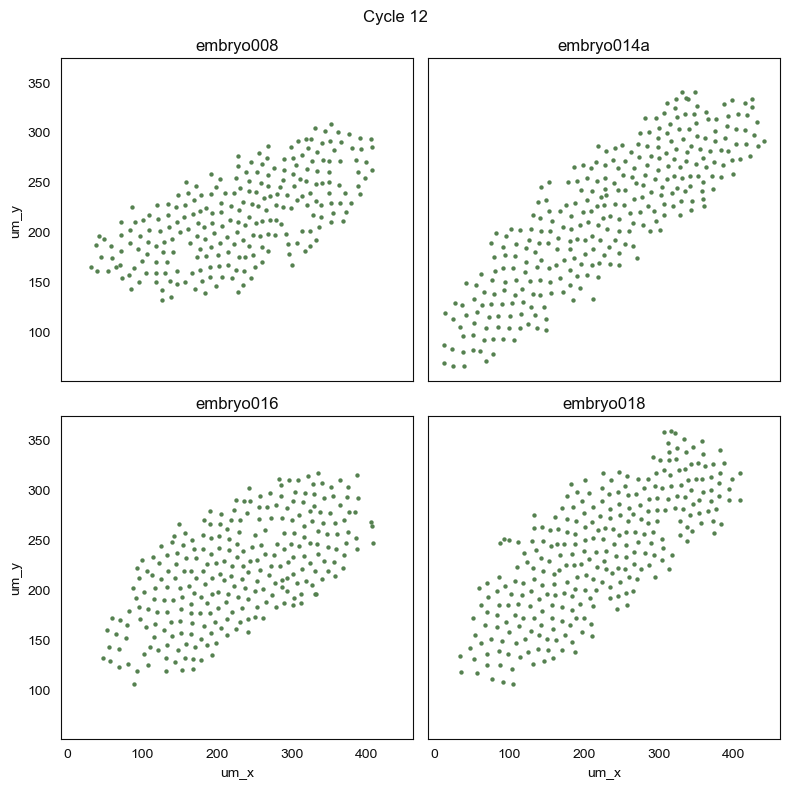

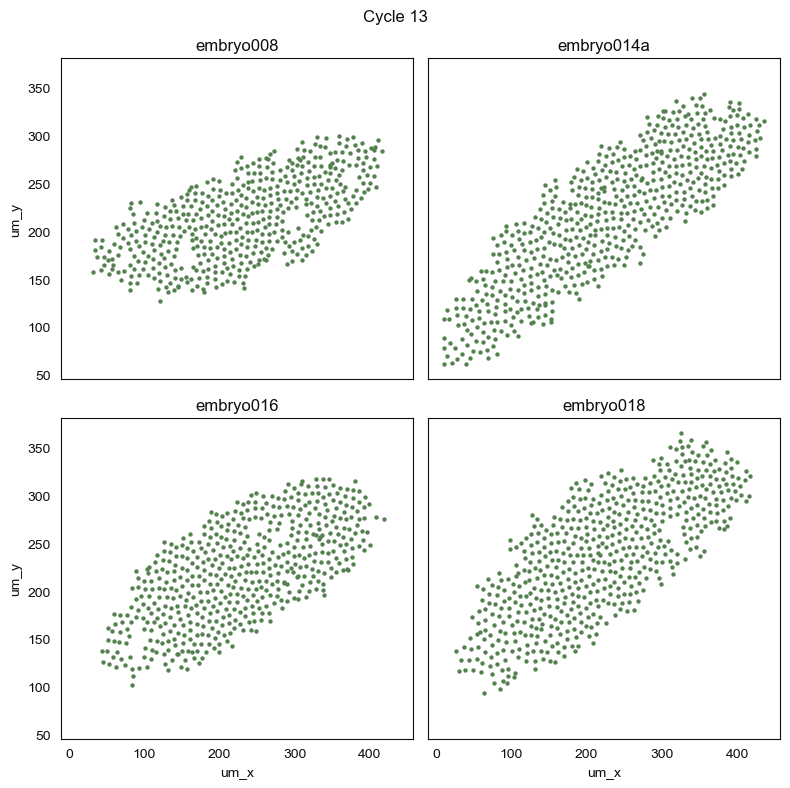

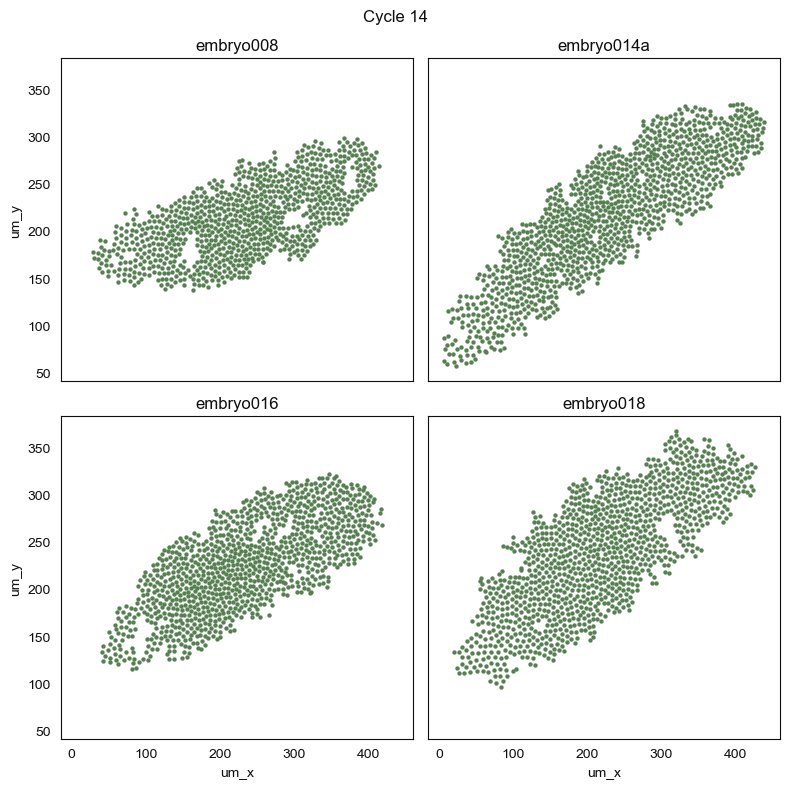

In [23]:

spot_df["x_vector_start"] = spot_df["e_track_id"].map(spot_df.groupby("e_track_id").first()["um_x"]) - spot_df["um_x"]
spot_df["y_vector_start"] = spot_df["e_track_id"].map(spot_df.groupby("e_track_id").first()["um_y"]) - spot_df["um_y"]

for cycle in range(11, 15):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
    for root, ax in zip(roots[1:], axes.flatten()):
        # fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        spots = spot_df[(spot_df["embryo"]==root) & (spot_df["cycle"]==cycle)]
        spots = spots.groupby("e_tracklet_id").last()
        
        sns.scatterplot(data=spots, x="um_x", y="um_y", ax=ax, s=10, color=palette["green"], legend=False, linewidths=0)
        x, y = spots["um_x"], spots["um_y"]
        u, v = spots["x_vector_start"], spots["y_vector_start"]
        ax.quiver(x, y, u, v, color="black", scale=1, scale_units="xy")
        ax.set_title(root)
    
    plt.suptitle(f"Cycle {cycle}")
    plt.tight_layout()
    this_plotpath = plotpath / "disquiver"
    this_plotpath.mkdir(exist_ok=True)
    plt.savefig(this_plotpath / f"cycle_{cycle}_root_{root}_distance_from_start.png", dpi=300)
    plt.show()
        

In [10]:
print(spot_df["distance_from_start"].describe())

count    567208.000000
mean         17.726797
std           9.588642
min           0.000000
25%          10.480388
50%          16.512319
75%          23.668761
max          60.036125
Name: distance_from_start, dtype: float64


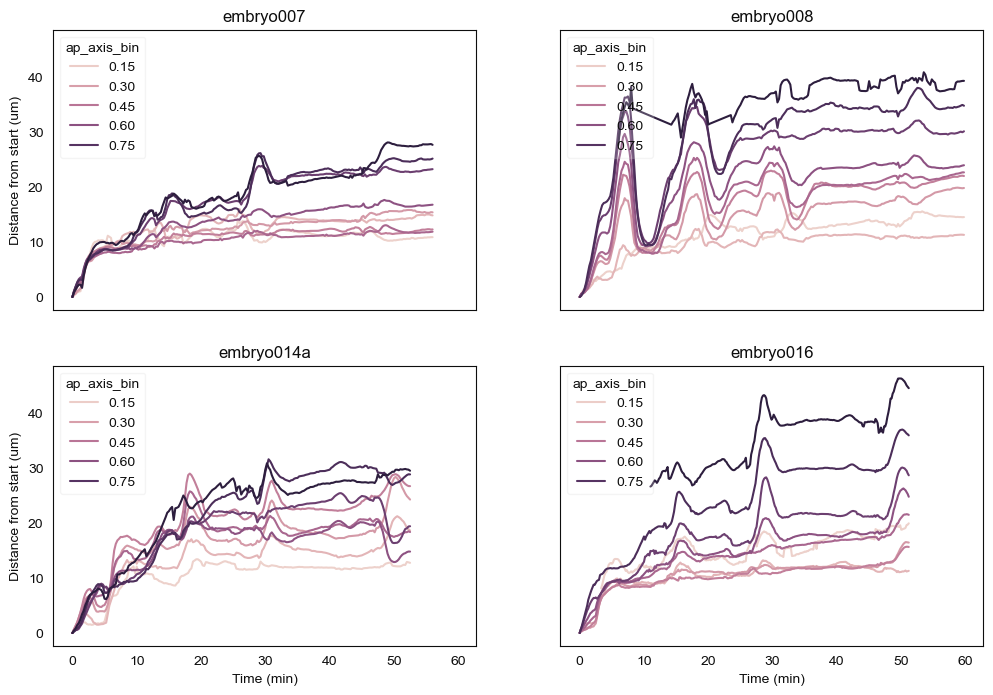

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for i, (root, ax) in enumerate(zip(roots, axes.flatten())):
    sns.lineplot(data=spot_df[spot_df["embryo"]==root], x="time", y="distance_from_start", hue="ap_axis_bin", ax=ax, palette=s_palette, errorbar=None)
    ax.set_title(root)
    
for ax in axes[:, 0]:
    ax.set_ylabel("Distance from start (um)")

for ax in axes[-1, :]:
    ax.set_xlabel("Time (min)")
    
plt.show()

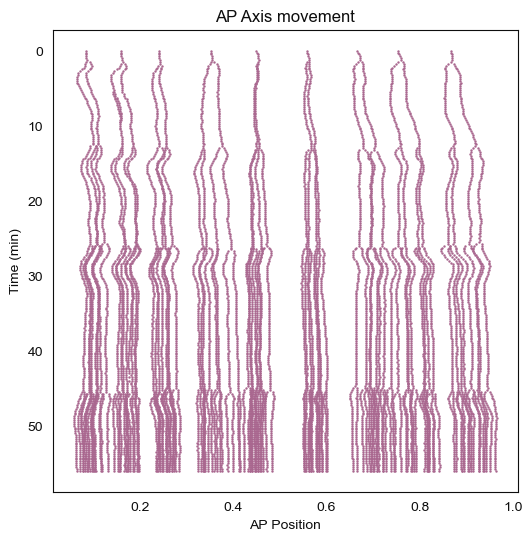

In [5]:
def lineage_plot(spot_df, x="ap_position", y="time", hue="embryo", sample_method="random", n_samples=10, ax=None, p="viridis"):
    """
    Plots a set of parameters for lineages
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    if sample_method == "random":
        t_ids = spot_df.track_id.sample(n_samples)
        sample = spot_df[spot_df.track_id.isin(t_ids)]
    elif sample_method == "spaced_start":
        first_frame_spots = spot_df[spot_df["cycle"] == spot_df["cycle"].min()]
        points = np.linspace(spot_df[x].min(), spot_df[x].max(), n_samples)
        sample = first_frame_spots.iloc[np.argmin(cdist(first_frame_spots[[x]], points.reshape(-1, 1)), axis=0)]["track_id"].unique()
    elif sample_method == "spaced_end":
        first_frame_spots = spot_df[spot_df["cycle"] == spot_df["cycle"].max()]
        points = np.linspace(spot_df[x].min(), spot_df[x].max(), n_samples)
        sample = first_frame_spots.iloc[np.argmin(cdist(first_frame_spots[[x]], points.reshape(-1, 1)), axis=0)]["track_id"].unique()
    else:
        raise ValueError("sample_method must be one of 'random', 'first', 'last'")
        
    data = spot_df[spot_df.track_id.isin(sample)]

    if hue == "error":
        data = data.sort_values(by="time")
        id_to_x = data.groupby("track_id").first()[x]
        h = np.abs(data[x] - data["track_id"].map(id_to_x))
        sns.scatterplot(x=np.array(data[x]), y=np.array(data[y]), hue=h, ax=ax, palette=p, linewidths=0.1)
    elif hue:
        h = data[hue]
        if p == "glasbey":
            p = glasbey.create_palette(len(data[hue].unique()))
        sns.scatterplot(x=np.array(data[x]), y=np.array(data[y]), hue=h, ax=ax, palette=p, linewidths=0.1)
    else:
        c = p
        sns.scatterplot(x=np.array(data[x]), y=np.array(data[y]), ax=ax, color=c, linewidths=0, s=3)
        
    
    
    if y == "time":
        ax.invert_yaxis()
    
    return ax

ax = lineage_plot(fully_tracked[fully_tracked["embryo"]==roots[0]], sample_method="spaced_start", hue=None, p=s_palette(0.5))
ax.set_xlabel("AP Position")
ax.set_ylabel("Time (min)")
ax.set_title("AP Axis movement")
# ax.legend(title="Tracklet ID", loc="upper left")

plt.savefig(plotpath / "lineage_plot.png")
plt.show()


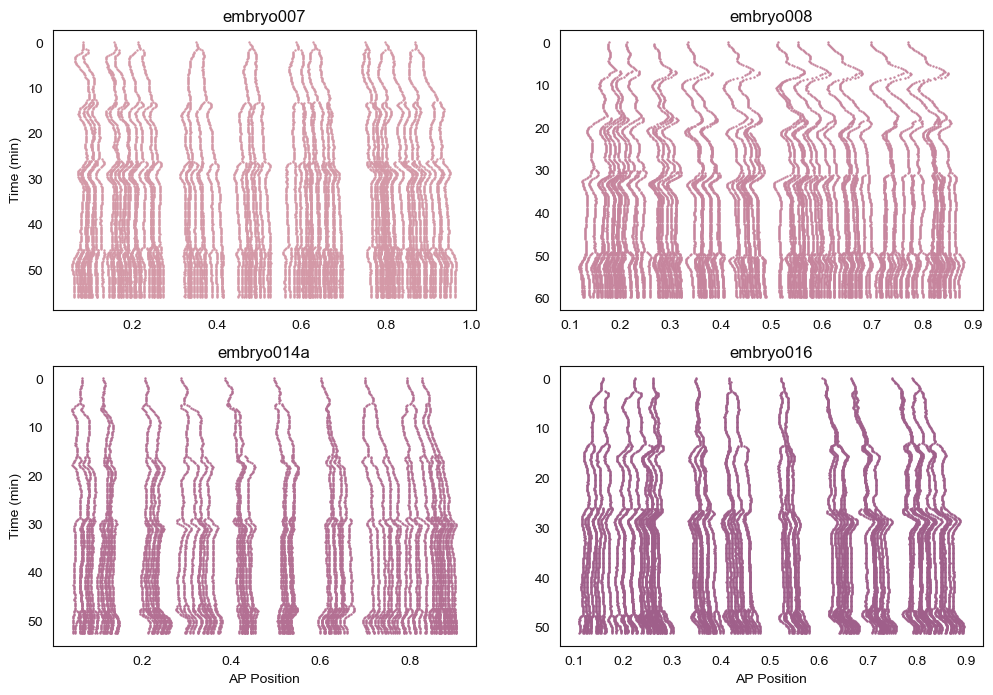

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, (root, ax) in enumerate(zip(roots, axes.flatten())):
    lineage_plot(spots_joined[(spots_joined["embryo"]==root) & 
                              (spots_joined["track_n_tracklets"]==31) &
                              (spots_joined["track_id"] != 0)
                 ].sort_values(by=["tracklet_id", "time"]), sample_method="spaced_end", hue=None, ax=ax, p=s_palette(i/10 + 0.25))
    ax.set_title(root)
    
    # ax.legend(title="Error", loc="upper left")

for ax in axes[:, 0]:
    ax.set_ylabel("Time (min)")

for ax in axes[-1, :]:
    ax.set_xlabel("AP Position")

plt.savefig(plotpath / "embryo_lineage_plot.png", dpi=300)

C:\Users\Harrison\AppData\Local\Temp\ipykernel_5932\2423242056.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = np.abs(last_frames.ap_position - last_frames.track_id.map(first_cycle.groupby("track_id").ap_position.first()))
C:\Users\Harrison\AppData\Local\Temp\ipykernel_5932\2423242056.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])
C:\Users\Harrison\AppData\Local\Temp\ipykernel_5932\2423242056.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


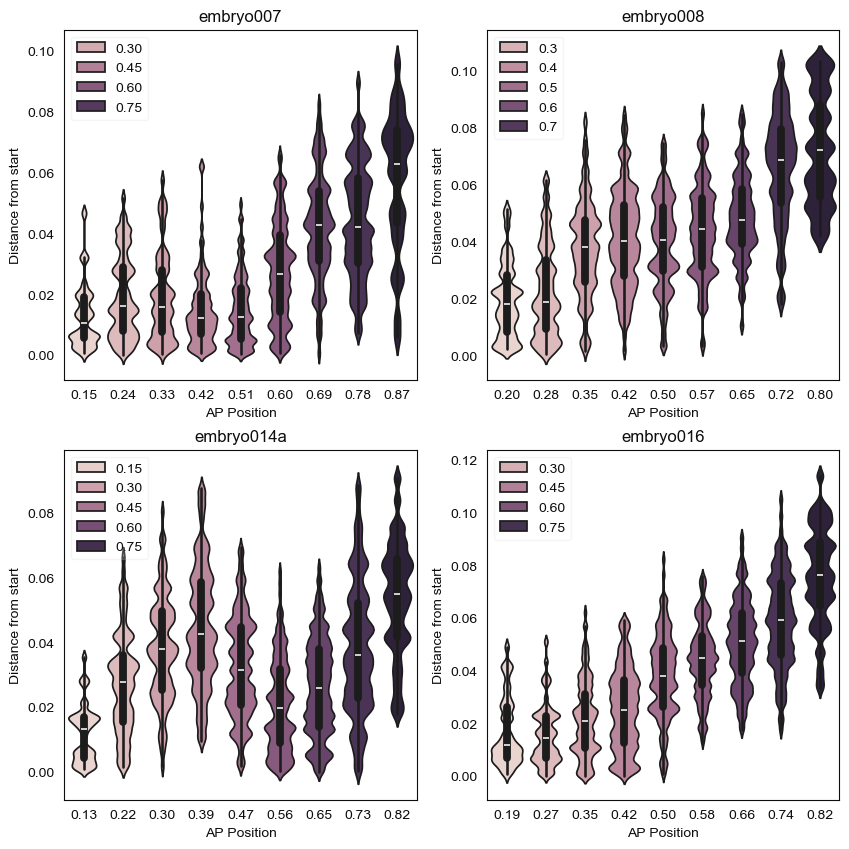

C:\Users\Harrison\AppData\Local\Temp\ipykernel_5932\2423242056.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])


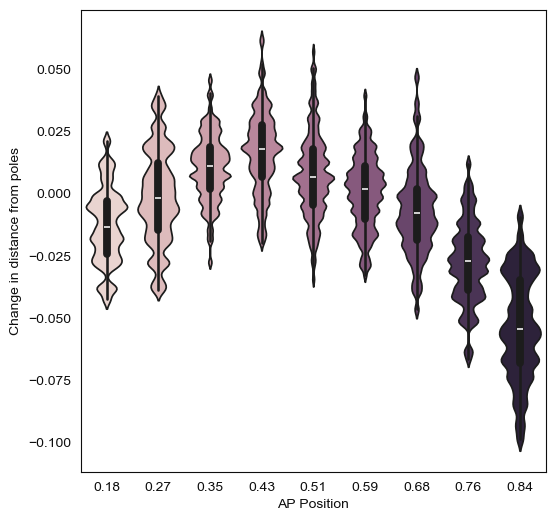

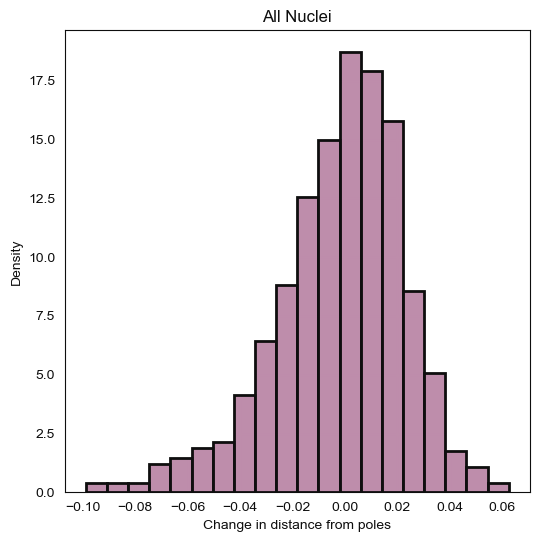

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ((root, spot_df), ax) in zip(spots.items(), axes.flatten()):
    spot_df = spot_df[(spot_df["track_n_tracklets"] >= 27) & 
                      (spot_df["track_id"] != 0)]
    last_frames = spot_df[spot_df["time"] == spot_df["time"].max()]
    first_cycle = spot_df[spot_df["cycle"] == spot_df["cycle"].min()]
    
    x = last_frames.ap_position
    x_binned = np.digitize(x, np.linspace(x.min(), x.max()+0.0001, 10)) * (x.max() - x.min()) / 10 + x.min()
    # x_binned = [f"{x:.2f}" for x in x_binned]
    
    y = np.abs(last_frames.ap_position - last_frames.track_id.map(first_cycle.groupby("track_id").ap_position.first()))
    
    sns.violinplot(x=x_binned, y=y, hue=x_binned, ax=ax, bw_adjust=0.25)
    
    ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])
    ax.set_title(root)
    ax.set_xlabel("AP Position")
    ax.set_ylabel("Distance from start")

plt.savefig(plotpath / "ap_axis_error.png")  
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))


spot_df = spots_joined[(spots_joined["track_n_tracklets"] >= 31) & 
                  (spots_joined["track_id"] != 0)].copy()
last_frames = spot_df[spot_df["time"] == spot_df["time"].max()]
first_cycle = spot_df[spot_df["cycle"] == spot_df["cycle"].min()]

x = last_frames.ap_position
x_binned = np.digitize(x, np.linspace(x.min(), x.max()+0.0001, 10)) * (x.max() - x.min()) / 10 + x.min()
# x_binned = [f"{x:.2f}" for x in x_binned]

y = (last_frames.d_poles - last_frames.e_track_id.map(first_cycle.groupby("e_track_id").d_poles.first()))

sns.violinplot(x=x_binned, y=y, hue=x_binned, ax=ax, bw_adjust=0.25, legend=False)

ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])
ax.set_xlabel("AP Position")
ax.set_ylabel("Change in distance from poles")

plt.savefig(plotpath / "ap_axis_error.png")  
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.histplot((y), bins=20, stat="density", ax=ax, color=s_palette(0.5), edgecolor=palette["black"], linewidth=2)
ax.set_xlabel("Change in distance from poles")



# mean, sd = y.median(), y.std()
# ax.axvline(mean, color="red")
# # plot normal
# x = np.linspace(y.min(), y.max(), 100)
# y = 1/(sd * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sd**2) )
# ax.plot(x, y, color="red")

ax.set_title("All Nuclei")


plt.savefig(plotpath / "ap_axis_error_hist.png")
plt.show()
    